# Cas Kaggle: League of Legends
### Autors
Eduard José García Mendeleac   NIU1672926  
Adrià Fernández Ortiz          NIU1672244
### Enllaços Relacionats
- GitHub: https://github.com/EduardGarMende/ApC_CasKaggle_LOL.git
- Base de Dades: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-soloq-ranked-games
### 1. Inicialitzar llibreries i dades

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.svm import SVC


df = pd.read_csv("data/lol_ranked_games.csv")
df

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,...,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
0,4546233126,1443000,1,10,-448,-147,-0.2,0,1,0,...,0,0,0,0,4,7,5,21,3,5
1,4546233126,1443000,1,12,-1306,-925,-0.6,0,1,0,...,0,0,0,0,6,11,6,28,4,6
2,4546233126,1443000,1,14,2115,2578,0.4,1,1,0,...,0,0,0,0,10,11,12,35,4,6
3,4546233126,1443000,1,16,1195,2134,0.4,1,1,0,...,0,0,1,0,10,12,12,45,6,10
4,4546233126,1443000,1,18,2931,4382,0.6,1,1,1,...,0,0,1,0,13,13,16,49,7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242567,4402156483,1774000,0,30,-8523,-13498,-1.6,1,1,1,...,0,0,1,1,33,41,50,80,18,17
242568,4379826739,1013000,0,10,-271,-1243,-0.2,0,1,0,...,0,0,0,0,6,5,6,18,1,2
242569,4379826739,1013000,0,12,-2013,-3493,-0.8,0,1,0,...,0,0,0,0,7,8,6,23,1,5
242570,4379826739,1013000,0,14,-2388,-4543,-0.8,0,1,0,...,0,0,0,0,10,13,9,27,5,6


### 2. Tractament de dades
- Busqueda de NaN's i de files duplicades:

In [3]:
# Comprovem si el dataset té Nans
print(df.isna().sum().sum()>0)

# Comprovem si hi ha duplicades
print("\nNombre de filas duplicades:")
print(df.duplicated().sum())

# Eliminar duplicades si és necessari
df.drop_duplicates(inplace=True)

False

Nombre de filas duplicades:
0


- Estudi dels atributs:

In [4]:
print("\nInformació general dels atributs:")
print(df.info())


Informació general dels atributs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242572 entries, 0 to 242571
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameId                   242572 non-null  int64  
 1   gameDuration             242572 non-null  int64  
 2   hasWon                   242572 non-null  int64  
 3   frame                    242572 non-null  int64  
 4   goldDiff                 242572 non-null  int64  
 5   expDiff                  242572 non-null  int64  
 6   champLevelDiff           242572 non-null  float64
 7   isFirstTower             242572 non-null  int64  
 8   isFirstBlood             242572 non-null  int64  
 9   killedFireDrake          242572 non-null  int64  
 10  killedWaterDrake         242572 non-null  int64  
 11  killedAirDrake           242572 non-null  int64  
 12  killedEarthDrake         242572 non-null  int64  
 13  killedElderDrake        

Dels atributs, el objectiu a classificar es el de hasWon. En una primera ullada, podem observar que si hi ha un 0 es que guanya l'equip contrari i si és un 1 guanya l'equip objectiu.

Comprovem la distribució del dataset:

In [5]:
print("Distribució de la classe objectiu:")
print(df['hasWon'].value_counts())

Distribució de la classe objectiu:
hasWon
0    121740
1    120832
Name: count, dtype: int64


- Com el dataset guarda varies imatges de cada pàrtida, seleccionem un frame exacte per a que, en aquest, la pàrtida ja estigui suficientment avançada per a que les diferencies entre els dos equips siguin prou significatives per a classificar el guanyador, evitant així que un frame molt inicial serveixi com a soroll per al model. Per aixó seleccionem el frame de 24:

In [6]:
df = df[df['frame'] == 24]
df

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,...,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
7,4546233126,1443000,1,24,9426,11980,1.8,1,1,2,...,1,0,1,0,26,15,36,85,11,14
21,4402345420,1790000,1,24,1249,5149,0.4,1,1,1,...,1,1,0,0,26,16,22,46,14,14
32,4546761795,2065000,0,24,5195,1107,0.4,1,1,0,...,0,1,1,0,24,12,40,40,10,14
52,4542452868,1646000,1,24,4613,5715,0.8,1,1,0,...,1,1,1,1,17,13,15,39,18,13
62,4545768539,2019000,1,24,-1492,-6711,-0.8,1,1,0,...,1,0,0,1,16,19,16,50,14,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242522,4515415826,1413000,0,24,-8334,-11101,-1.4,0,1,0,...,0,1,1,1,18,27,26,41,7,18
242530,4412039545,1510000,1,24,5109,-519,0.0,1,1,0,...,0,0,0,0,25,26,33,232,22,10
242539,4546226831,2135000,0,24,-2204,-4553,-0.6,1,1,0,...,1,0,0,0,13,19,18,74,14,13
242553,4546686770,1845000,1,24,-25,-7195,-1.2,1,1,0,...,1,0,0,1,33,25,45,277,11,10


- Eliminem la columna de gameId i frame que són innecessàries per a la classificació:

In [7]:
df = df.drop(["gameId", "frame"], axis=1)

- Tractament d'atributs categórics i no categórics:

Com hem vist abans, tots els atributs són numérics, per tant, no fa falta codificarlos. Però això no vol dir que tots els atributs siguin no categòrics, veient la base de dades podem catalogar els següents atributs com categòrics:     
-hasWon  
-isFirstBlood  
-isFirstTower  

Dels no categòrics els normalitzem per tenir rangs de dades equivalents, aplicant Mini-Max.

In [8]:
columns_to_normalize = ['gameDuration', 'goldDiff', 'expDiff', 'champLevelDiff', 'killedFireDrake', 'killedWaterDrake',
       'killedAirDrake', 'killedEarthDrake', 'killedElderDrake',
       'lostFireDrake', 'lostWaterDrake', 'lostAirDrake', 'lostEarthDrake',
       'lostElderDrake', 'killedBaronNashor', 'lostBaronNashor',
       'killedRiftHerald', 'lostRiftHerald', 'destroyedTopInhibitor',
       'destroyedMidInhibitor', 'destroyedBotInhibitor', 'lostTopInhibitor',
       'lostMidInhibitor', 'lostBotInhibitor', 'destroyedTopNexusTurret',
       'destroyedMidNexusTurret', 'destroyedBotNexusTurret',
       'lostTopNexusTurret', 'lostMidNexusTurret', 'lostBotNexusTurret',
       'destroyedTopBaseTurret', 'destroyedMidBaseTurret',
       'destroyedBotBaseTurret', 'lostTopBaseTurret', 'lostMidBaseTurret',
       'lostBotBaseTurret', 'destroyedTopInnerTurret',
       'destroyedMidInnerTurret', 'destroyedBotInnerTurret',
       'lostTopInnerTurret', 'lostMidInnerTurret', 'lostBotInnerTurret',
       'destroyedTopOuterTurret', 'destroyedMidOuterTurret',
       'destroyedBotOuterTurret', 'lostTopOuterTurret', 'lostMidOuterTurret',
       'lostBotOuterTurret', 'kills', 'deaths', 'assists', 'wardsPlaced',
       'wardsDestroyed', 'wardsLost']

df[columns_to_normalize] = df[columns_to_normalize].astype(float)

# Subset de datos
data = df[columns_to_normalize]

# Aplicar Min-Max Scaling
min_max_scaler = MinMaxScaler()
data_minmax = pd.DataFrame(min_max_scaler.fit_transform(data), columns=columns_to_normalize, index=data.index)

df.update(data_minmax)


### 3. Millors atributs per a la predicció
- Separem la variable objectiu de les variables independents:

In [9]:
X = df.drop(columns=['hasWon'])
y = df['hasWon']

- Fem una primera classificació de l'importancia de cada atribut aplicant un Random Forest:

In [10]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Obtenir la importancia de les característiques
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importancia de característiques (Random Forest):")
print(feature_importances)

Importancia de característiques (Random Forest):
                    Feature  Importance
1                  goldDiff    0.185645
2                   expDiff    0.141899
3            champLevelDiff    0.084859
0              gameDuration    0.083358
50                    kills    0.048017
51                   deaths    0.047530
52                  assists    0.042413
53              wardsPlaced    0.030940
55                wardsLost    0.027694
54           wardsDestroyed    0.027027
40  destroyedBotInnerTurret    0.024356
43       lostBotInnerTurret    0.019461
17          lostBaronNashor    0.015340
16        killedBaronNashor    0.013407
9          killedEarthDrake    0.011221
49       lostBotOuterTurret    0.010710
11            lostFireDrake    0.010289
46  destroyedBotOuterTurret    0.010178
6           killedFireDrake    0.010076
18         killedRiftHerald    0.009763
19           lostRiftHerald    0.009592
14           lostEarthDrake    0.009275
7          killedWaterDrake    

Veient la classificació podem veure que hi ha atributs amb molt poca importància, per tant eliminem els atributs que estiguin per sota de un 0.0083:

In [11]:
df = df.drop(['isFirstTower', 'lostAirDrake', 'destroyedBotInhibitor', 'destroyedBotNexusTurret', 
              'lostMidInnerTurret', 'destroyedMidOuterTurret', 'lostMidOuterTurret', 'destroyedTopOuterTurret', 
              'lostTopOuterTurret', 'lostBotNexusTurret', 'destroyedTopInnerTurret', 'lostTopInnerTurret', 
              'lostBotInhibitor', 'destroyedMidNexusTurret', 'destroyedTopNexusTurret', 'lostMidNexusTurret', 
              'lostTopNexusTurret', 'lostBotBaseTurret', 'destroyedMidInhibitor', 'destroyedBotBaseTurret', 
              'lostTopInhibitor', 'lostMidInhibitor', 'destroyedTopInhibitor', 'killedElderDrake', 'isFirstBlood', 
              'lostElderDrake', 'lostMidBaseTurret', 'destroyedTopBaseTurret', 'destroyedMidBaseTurret', 'lostTopBaseTurret'], axis=1)

X = df.drop(columns=['hasWon'])
y = df['hasWon']

- Fem un estudi més exhaustiu per a seleccionar els millors atributs utilitzant Recursive Feature Elimination (RFE) que selecciona les millors característiques optimitzant un model base:

In [12]:
model = LogisticRegression(max_iter=10000, random_state=42)

rfe = RFE(model, n_features_to_select=15)  # Seleccionar las 5 mejores características
rfe.fit(X, y)

# Ver las mejores características seleccionadas
selected_features = X.columns[rfe.support_]
print("Características seleccionadas por RFE:")
print(selected_features)

Características seleccionadas por RFE:
Index(['gameDuration', 'goldDiff', 'expDiff', 'champLevelDiff',
       'killedFireDrake', 'killedWaterDrake', 'killedAirDrake',
       'killedEarthDrake', 'lostFireDrake', 'lostWaterDrake', 'lostEarthDrake',
       'destroyedMidInnerTurret', 'kills', 'deaths', 'wardsLost'],
      dtype='object')


Per tant, ens quedem amb aquests 15 atributs:

In [13]:
columns_to_keep = ['hasWon', 'gameDuration', 'goldDiff', 'expDiff', 'champLevelDiff',
       'killedFireDrake', 'killedWaterDrake', 'killedAirDrake',
       'killedEarthDrake', 'lostFireDrake', 'lostWaterDrake', 'lostEarthDrake',
       'destroyedMidInnerTurret', 'kills', 'deaths', 'wardsLost']

df = df[columns_to_keep]

X = df.drop(columns=['hasWon'])
y = df['hasWon']

- Ara búsquem correlacions entre els atributs per a evitar columnes redundants:

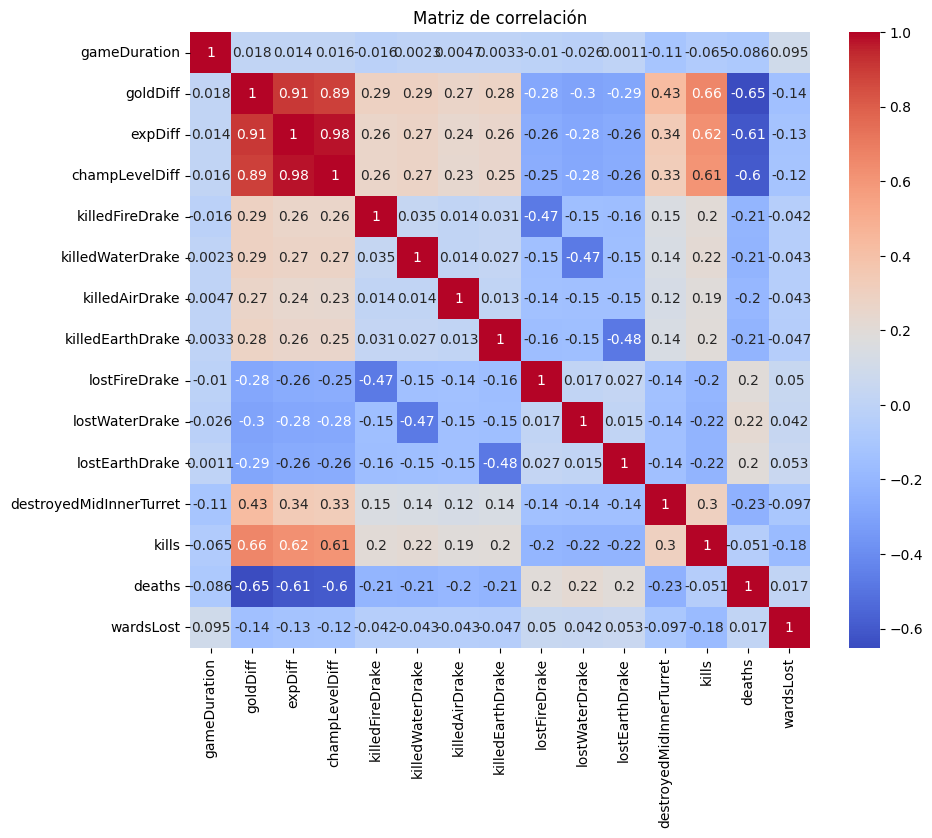

Características altamente correlacionadas:
{'goldDiff', 'expDiff', 'champLevelDiff'}


In [14]:
corr_matrix = X.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

# Identificar pares altamente correlacionados
threshold = 0.85
correlated_features = set(
    col for col in corr_matrix.columns for row in corr_matrix.index
    if abs(corr_matrix.loc[row, col]) > threshold and col != row
)
print("Características altamente correlacionadas:")
print(correlated_features)

Podem veure que les columes corresponents als atributs expDiff, goldDiff i champLevelDiff estan fortament correlacionades ja que en una partida la diferència dexperiència es tradueix en una diferència de nivell entre els campions. A més, el fet que hi hagi una diferència d'or normalment es tradueix que també hi hagi una diferència d'experiència, per tant eliminem la diferència entre el nivell dels campions i ens quedem amb la diferència d'experiència i d'or.

In [15]:
df = df.drop(['champLevelDiff'], axis=1)

X = df.drop(columns=['hasWon'])
y = df['hasWon']

### 4. Entrenament del Model

Primerament, dividim el dataset entre entrenament i test:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Per elaborar el nostre model de predicció compararem els resultats obtinguts amb diferents classificadors. Primerament farem un estudi preliminar per seleccionar els millors classificadors:
- KNN:

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

prediccions = knn.predict(X_test)
accuracy = accuracy_score(y_test, prediccions)

print(f"Presició del model amb KNN: {accuracy:.2f}")

Presició del model amb KNN: 0.81


- Regressió Logística:

In [18]:
logistic_reg = LogisticRegression(random_state=42, max_iter=5000)
logistic_reg.fit(X_train, y_train)

prediccions = logistic_reg.predict(X_test)
accuracy = accuracy_score(y_test, prediccions)

print(f"Presició del model amb Regressió Logística: {accuracy:.2f}")

Presició del model amb Regressió Logística: 0.83


- Random Forest:

In [19]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

prediccions = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, prediccions)

print(f"Presició del model amb Random Forest: {accuracy:.2f}")

Presició del model amb Random Forest: 0.83


- SVM (Maquines de Vectors de Support):

In [20]:
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

prediccions = svm.predict(X_test)
accuracy = accuracy_score(y_test, prediccions)

print(f"Presició del model amb SVM: {accuracy:.2f}")

Presició del model amb SVM: 0.83


En aquest primer entrenament, veiem que tots els classificadors donen un accuracy bastant alt. Ara buscarem els millors hiperparametres utilitzant Random Search amb Cross Validation per als classificadors SVM i Random Forest:

- Millors hiperparàmetres Random Forest:

In [21]:
hiperparametros_RF = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=hiperparametros_RF,
    cv=3,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Millors hiperparàmetres trobats:")
print(random_search.best_params_)

best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisió del model RF optimitzat: {accuracy:.2f}")

C:\Users\emend\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Millors hiperparàmetres trobats:
{'n_estimators': 300, 'max_depth': 30, 'bootstrap': True}

Precisió del model RF optimitzat: 0.83


- Millors hiperparàmetres SVM:

In [22]:
hiperparametros_SVM = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4]
}

random_search = RandomizedSearchCV(
    estimator=SVC(random_state=42),
    param_distributions=hiperparametros_SVM,
    cv=3,
    random_state=42,
)

random_search.fit(X_train, y_train)

print("Millors hiperparàmetres trobats:")
print(random_search.best_params_)

best_svm_model = random_search.best_estimator_
y_pred = best_svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisió del model SVM optimitzat: {accuracy:.2f}")

Millors hiperparàmetres trobats:
{'kernel': 'linear', 'gamma': 0.001, 'degree': 3, 'C': 0.1}

Precisió del model SVM optimitzat: 0.83


Com que no hi ha millora amb els millors hiperparàmetres, busquem els millors hiperparàmetres en els altres dos classificadors:

- Millors hiperparàmetres KNN:

In [ ]:
hiperparametros_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

random_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=hiperparametros_KNN,
    cv=3,
    random_state=42,
)

random_search.fit(X_train, y_train)

print("Millors hiperparàmetres trobats:")
print(random_search.best_params_)

best_knn_model = random_search.best_estimator_
y_pred = best_knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisió del model KNN optimitzat: {accuracy:.2f}")

Millors hiperparàmetres trobats:
{'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'metric': 'minkowski'}

Precisió del model KNN optimitzat: 0.82


- Millors hiperparàmetres Regressió Logística:

In [26]:
hiperparametros_LR = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear']
}

random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=hiperparametros_LR,
    cv=3,
    random_state=42,
)

random_search.fit(X_train, y_train)

print("Millors hiperparàmetres trobats:")
print(random_search.best_params_)

best_lr_model = random_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisió del model de Regressió Logística optimitzat: {accuracy:.2f}")

Millors hiperparàmetres trobats:
{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

Precisió del model de Regressió Logística optimitzat: 0.83


### 5. Visualització de Resultats
Com tots els models donen una precisió similiar, visualitzem els resultats de només un. Visualitzem la Confusion Matrix y la corva ROC del model generat amb Regressió Logística:

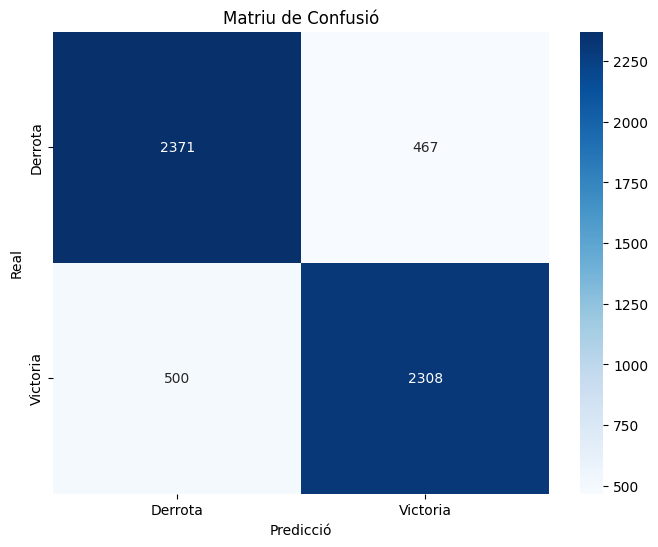

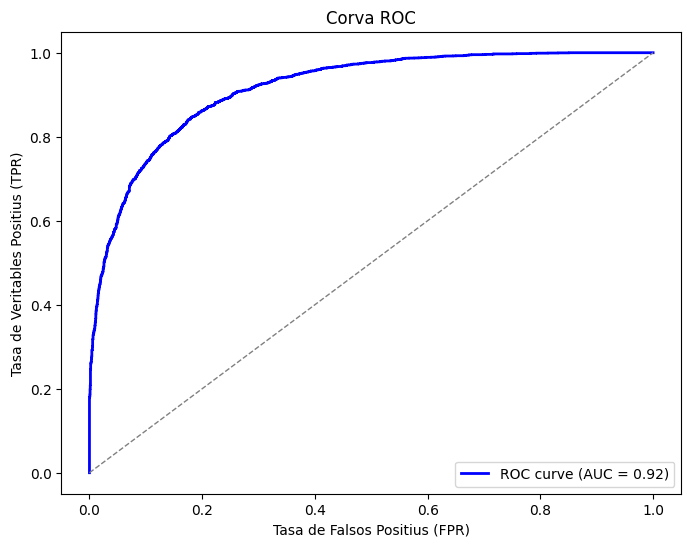

In [27]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
    plt.xlabel('Predicció')
    plt.ylabel('Real')
    plt.title('Matriu de Confusió')
    plt.show()

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('Tasa de Falsos Positius (FPR)')
    plt.ylabel('Tasa de Veritables Positius (TPR)')
    plt.title('Corva ROC')
    plt.legend(loc="lower right")
    plt.show()

y_pred = best_lr_model.predict(X_test)
y_prob = best_lr_model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, y_pred)

plot_roc_curve(y_test, y_prob)

### 6. Conclusions


Els resultats obtinguts mostren que els quatre models implementats (KNN, Regressió Logística, Random Forest i SVM) ofereixen un rendiment molt similar, amb precisions al voltant del 82-83% fins i tot després d'optimitzar els seus hiperparàmetres. Aquest comportament posa de manifest que les dades disponibles permeten capturar la informació necessària per discriminar correctament entre classes sense que cap model destaqui significativament sobre els altres.

El fet que la precisió es mantingui estable independentment del model indica que el conjunt de dades conté una separació clara i ben definida entre classes, la qual cosa facilita que diversos algorismes puguin aconseguir resultats gairebé idèntics. A més, l’optimització dels hiperparàmetres no ha suposat una millora substancial respecte als resultats inicials, fet que suggereix que els models ja funcionaven properament al seu rendiment òptim des del principi.

En aquest cas, es pot concloure que qualsevol dels models analitzats seria adequat per a la tasca proposada, ja que tots aconsegueixen un rendiment molt similar en termes d’accuracy. Això reflecteix que els models implementats han estat ben ajustats i que les dades disponibles són suficients per assolir aquest nivell de precisió.